# Imports

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

# Function to show logits

In [ ]:
# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 2
# Do not show labels with lower score than this:
MIN_SCORE = 0.01 

def show_preds(logits, image, labels, correct_label=None):
  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  # fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)
  # ax1, ax2 = axes[0]
  # ax1.axis('off')
  # ax1.imshow(image)
  
  # if correct_label is not None:
  #   ax1.set_title(labels[correct_label])

  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))

  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    # predicting in tf_flowers label space
    classes.append(labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  # ax2.barh(np.arange(len(scores)) + 0.1, scores)
  # ax2.set_xlim(0, 100)
  # ax2.set_yticks(np.arange(len(scores)))
  # ax2.yaxis.set_ticks_position('right')
  # ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  # ax2.invert_xaxis()
  # ax2.invert_yaxis()
  # ax2.set_xlabel('Prediction probabilities', fontsize=11)
  return scores

In [ ]:
labels = ['positive', 'negative']

# Models

In [ ]:
# Our model
model_url = "https://tfhub.dev/google/bit/m-r152x4/1"
module = hub.KerasLayer(model_url)

# Load model fine-tuned on ImageNet
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

In [ ]:
export_module_dir = 'drive/MyDrive/models/m-r152x4'
tf.saved_model.save(module, export_module_dir)

NameError: ignored

In [ ]:
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

ValueError: ignored

# Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

labels=['neg_tweet', 'pos_tweet']
data_dir = pathlib.Path('drive/MyDrive/dogevision/processed')

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = labels
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

# 217 positive
# 436 negative
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# load real tweets
labels=['neg_tweet', 'pos_tweet']
data_dir = pathlib.Path('drive/MyDrive/tweets')

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = labels
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

# 217 positive
# 436 negative
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Split into train and test sets
# We have checked that the classes are reasonably balanced.
train_split = 0.9
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

--2021-06-11 07:26:27--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.211.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.6’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-06-11 07:26:27 (147 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.6’ saved [21675/21675]



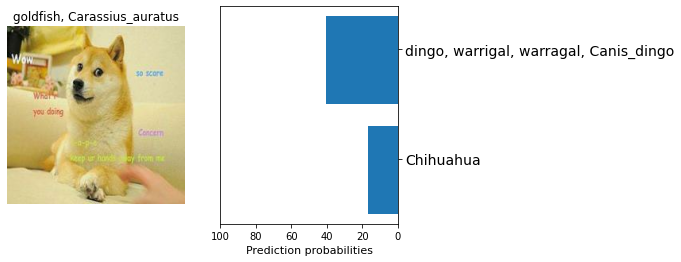

In [ ]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)

  # Run model on image
  logits = imagenet_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], imagenet_int_to_str, features['label'].numpy())

# Finetuned model

In [ ]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [ ]:
# Hyper parameteres rule
# images are bigger than 96x96 so
RESIZE_TO = 512
CROP_TO = 480
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

BATCH_SIZE = 1
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [ ]:
tf.device('/device:GPU:0')

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10,
    # epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/10
10/10 [==============================] - 45s 4s/step - loss: 0.6855 - accuracy: 0.4000 - val_loss: 0.5688 - val_accuracy: 0.6970
Epoch 2/10
10/10 [==============================] - 34s 4s/step - loss: 0.4363 - accuracy: 0.9000 - val_loss: 0.4420 - val_accuracy: 0.7424
Epoch 3/10
10/10 [==============================] - 34s 4s/step - loss: 0.4549 - accuracy: 0.7000 - val_loss: 0.3722 - val_accuracy: 0.7879
Epoch 4/10
10/10 [==============================] - 34s 4s/step - loss: 0.3460 - accuracy: 0.8000 - val_loss: 0.3547 - val_accuracy: 0.8636
Epoch 5/10
10/10 [==============================] - 34s 4s/step - loss: 0.3246 - accuracy: 0.9000 - val_loss: 0.4583 - val_accuracy: 0.7727
Epoch 6/10
10/10 [==============================] - 34s 4s/step - loss: 0.5902 - accuracy: 0.7000 - val_loss: 0.3345 - val_accuracy: 0.8030
Epoch 7/10
10/10 [==============================] - 34s 4s/step - loss: 0.6578 - accuracy: 0.7000 - val_loss: 0.7270 - val_accuracy: 0.6515
Epoch 8/10
10/10 [==

In [ ]:
export_module_dir = 'drive/MyDrive/models/m-r152x4-trained-on-doge'
tf.saved_model.save(model, export_module_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: drive/MyDrive/models/m-r152x4-trained-on-doge/assets


INFO:tensorflow:Assets written to: drive/MyDrive/models/m-r152x4-trained-on-doge/assets


In [ ]:
saved_module = hub.KerasLayer('drive/MyDrive/models/m-r152x4-trained-on-doge', trainable=True)

OSError: ignored

In [ ]:
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

In [ ]:
validation_acc

[0.9242424368858337,
 0.8939393758773804,
 0.9696969985961914,
 0.9696969985961914,
 0.939393937587738,
 0.9545454382896423,
 1.0,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914]

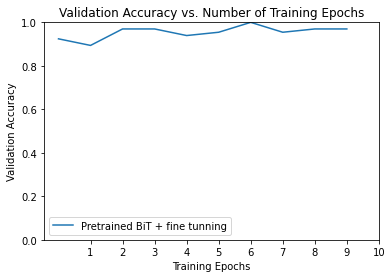

In [ ]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(0,10), validation_acc, label="Pretrained BiT + fine tunning")
plt.ylim((0,1.))
plt.xticks(np.arange(1, 11, 1.0))
plt.legend()
plt.show()

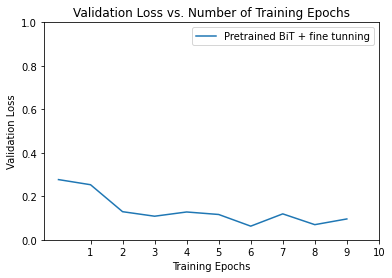

In [ ]:
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(0,10), validation_loss, label="Pretrained BiT + fine tunning")
plt.ylim((0,1.))
plt.xticks(np.arange(1, 11, 1.0))
plt.legend()
plt.show()

In [ ]:
# Visualise predictions from new model
count_fp = 0 
count_tp = 0
count_fn = 0
count_tn = 0
for features in ds:
  image = features['image']
  image = preprocess_image(image)
  
  # Run model on image
  logits = model(image)
  
  # Show image and predictions
  proba = show_preds(logits, image[0], labels, features['label'].numpy())
  print()
  
  pred = None
  if proba[0] >= proba[1]:
    # negative pred
    pred = 0
  else:
    # positive pred
    pred = 1
  
  real = features['label'].numpy()

  if pred == 1 and real == 0:
    count_fp += 1

  if pred == 1 and real == 1:
    count_tp += 1

  if pred == 0 and real == 1:
    count_fn += 1

  if pred == 0 and real == 0:
    count_tn += 1

print(count_tp, count_tn)
print(count_fp, count_fn)

KeyboardInterrupt: ignored

tf.Tensor([[-0.18048924  0.18048914]], shape=(1, 2), dtype=float32)


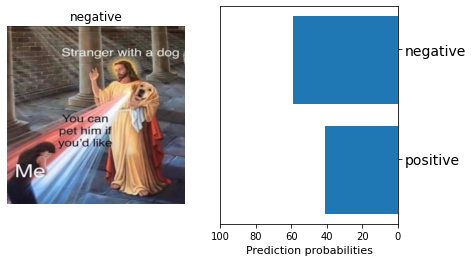

In [ ]:
# Load image (image provided is CC0 licensed)
img_url = "https://pbs.twimg.com/media/E2Bn5RcVkAESH6E?format=jpg&name=small"
image = load_image_from_url(img_url)
image = tf.image.resize(image, [CROP_TO, CROP_TO])

# Run model on image
logits = model(image)

# Show image and predictions
# show_preds(logits, image[0])
show_preds(logits, image[0], labels, features['label'].numpy())
print(logits)

In [ ]:
model.summary()

Model: "my_bi_t_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  16386     
_________________________________________________________________
keras_layer (KerasLayer)     multiple                  928340224 
Total params: 928,356,610
Trainable params: 16,386
Non-trainable params: 928,340,224
_________________________________________________________________


In [ ]:
data_dir = pathlib.Path('drive/MyDrive/elon_tweets_img/images')

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = labels
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

# 217 positive
# 436 negative
list_tweets_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))
tweets_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tf.Tensor([[ 2.7483425 -2.748342 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[-3.716173   3.7161732]], shape=(1, 2), dtype=float32)


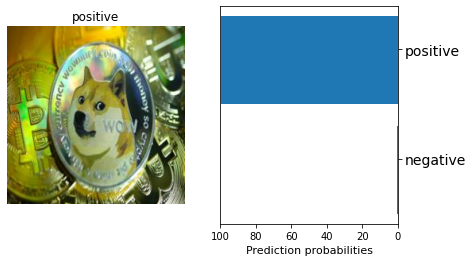

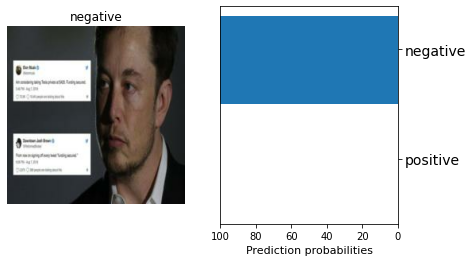

In [ ]:
# Visualise predictions from new model
count = 0
for features in tweets_ds:
  image = features['image']
  image = preprocess_image(image)
  
  # Run model on image
  logits = model(image)
  
  # Show image and predictions
  show_preds(logits, image[0], labels, features['label'].numpy())
  print(logits)
  if count == 1:
    break
  count += 1